In [5]:
import UnicornPy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import socket
from joblib import load
import pyriemann

mne.set_log_level('ERROR')

def psdplot(filename, chans=None, header=0, bco=600):
    raw = pd.read_csv(filename, header=header).to_numpy().T
    raw = raw[0:8,:]
    fs = 250
    ch_names = ['Fz','C3','Cz','C4','Pz','PO7','Oz','PO8']
    info = mne.create_info(ch_names, fs)
    data_mne = mne.io.RawArray(raw,info)
    data_mne.filter(2,30,picks=ch_names) # only for raw python data
    data_mne.notch_filter(freqs=[50], picks=ch_names)
    data_mne.plot_psd(picks=ch_names if chans==None else chans, fmax=60, tmin=4)
    plt.show()
    # mne.viz.plot_raw(data_mne)
    plt.plot(data_mne.times[bco:], data_mne.get_data(picks='Cz').squeeze()[bco:])
    plt.ylim([-200,200])

In [6]:
TestsignaleEnabled = False;
FrameLength = 1;
AcquisitionDurationInSeconds = 40;
DataFile = "data.csv";

In [7]:
def acquire():
    try:
            # Get available devices.
            #-------------------------------------------------------------------------------------

            # Get available device serials.
            deviceList = UnicornPy.GetAvailableDevices(True)

            if len(deviceList) <= 0 or deviceList is None:
                raise Exception("No device available.Please pair with a Unicorn first.")

            # Print available device serials.
            print("Available devices:")
            i = 0
            for device in deviceList:
                print("#%i %s" % (i,device))
                i+=1

            # Request device selection.
            print()
            deviceID = 0

            # Open selected device.
            #-------------------------------------------------------------------------------------
            print()
            print("Trying to connect to '%s'." %deviceList[deviceID])
            device = UnicornPy.Unicorn(deviceList[deviceID])
            print("Connected to '%s'." %deviceList[deviceID])
            print()

            # Create a file to store data.
            file = open(DataFile, "wb")

            # Initialize acquisition members.
            #-------------------------------------------------------------------------------------
            numberOfAcquiredChannels= device.GetNumberOfAcquiredChannels()
            configuration = device.GetConfiguration()

            # Print acquisition configuration
            print("Acquisition Configuration:");
            print("Sampling Rate: %i Hz" %UnicornPy.SamplingRate);
            print("Frame Length: %i" %FrameLength);
            print("Number Of Acquired Channels: %i" %numberOfAcquiredChannels);
            print("Data Acquisition Length: %i s" %AcquisitionDurationInSeconds);
            print();

            # Allocate memory for the acquisition buffer.
            receiveBufferBufferLength = FrameLength * numberOfAcquiredChannels * 4
            receiveBuffer = bytearray(receiveBufferBufferLength)

            try:
                # Start data acquisition.
                #-------------------------------------------------------------------------------------
                device.StartAcquisition(TestsignaleEnabled)
                print("Data acquisition started.")

                # Calculate number of get data calls.
                numberOfGetDataCalls = int(AcquisitionDurationInSeconds * UnicornPy.SamplingRate / FrameLength);
            
                # Limit console update rate to max. 25Hz or slower to prevent acquisition timing issues.                   
                consoleUpdateRate = int((UnicornPy.SamplingRate / FrameLength) / 25.0);
                if consoleUpdateRate == 0:
                    consoleUpdateRate = 1

                # Acquisition loop.
                #-------------------------------------------------------------------------------------
                for i in range (0,numberOfGetDataCalls):
                    # Receives the configured number of samples from the Unicorn device and writes it to the acquisition buffer.
                    device.GetData(FrameLength,receiveBuffer,receiveBufferBufferLength)

                    # Convert receive buffer to numpy float array 
                    data = np.frombuffer(receiveBuffer, dtype=np.float32, count=numberOfAcquiredChannels * FrameLength)
                    data = np.reshape(data, (FrameLength, numberOfAcquiredChannels))
                    np.savetxt(file,data,delimiter=',',fmt='%.3f',newline='\n')
                    
                    # Update console to indicate that the data acquisition is running.
                    if i % consoleUpdateRate == 0:
                        print('.',end='',flush=True)

                # Stop data acquisition.
                #-------------------------------------------------------------------------------------
                device.StopAcquisition();
                print()
                print("Data acquisition stopped.");

            except UnicornPy.DeviceException as e:
                print(e)
            except Exception as e:
                print("An unknown error occured. %s" %e)
            finally:
                # release receive allocated memory of receive buffer
                del receiveBuffer

                #close file
                file.close()

                # Close device.
                #-------------------------------------------------------------------------------------
                del device
                print("Disconnected from Unicorn")

    except UnicornPy.DeviceException as e:
        print(e)
    except Exception as e:
        print("An unknown error occured. %s" %e)

        #input("\n\nPress ENTER key to exit")

In [61]:
DataFile = "feetMI15.csv";
acquire()

Available devices:
#0 UN-2019.05.78


Trying to connect to 'UN-2019.05.78'.
Connected to 'UN-2019.05.78'.

Acquisition Configuration:
Sampling Rate: 250 Hz
Frame Length: 1
Number Of Acquired Channels: 17
Data Acquisition Length: 40 s

Data acquisition started.
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

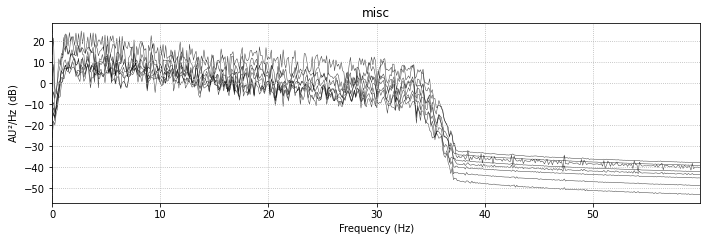

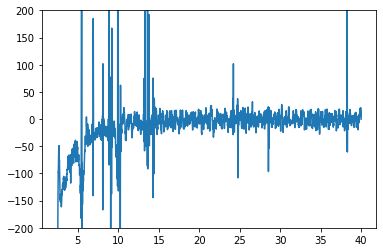

In [62]:
psdplot('feetMI15.csv')